In [65]:
import hydra
from glob import  glob
from rosa.data import  RosaDataModule, create_io_paths
from rosa.modeling import  RosaLightningModule


BASE_DIR = "/Users/nsofroniew/Documents/GitHub/rosa/conf/" # /Users/nsofroniew/Documents/GitHub/ or /home/ec2-user/

with hydra.initialize_config_dir(config_dir=BASE_DIR):
    config = hydra.compose(config_name="config")
    config.paths.base = '/Users/nsofroniew/Documents/data/multiomics/cell_census'

    _, output_path = create_io_paths(config.paths)

    config.data_module.data.mask = 0.05
    # Create Data Module
    rdm = RosaDataModule(
        output_path,
        config=config.data_module,
    )
    rdm.setup()

    # Load model from checkpoint
    rlm = RosaLightningModule(
        var_input=rdm.var_input,
        config=config.module,
    )
    print(rlm)
    print(output_path)

/var/folders/6n/b_zkz2ns3_l02s3g4lnlklxr0000gq/T/ipykernel_70633/3667613276.py:9: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=BASE_DIR):
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


RosaLightningModule(
  (model): RosaTransformer(
    (expression_embedding): BinnedEmbed(
      (model): Sequential(
        (embedding): Embedding(17, 64)
        (layer_norm): Identity()
        (dropout): Dropout(p=0, inplace=False)
      )
    )
    (var_embedding): Sequential(
      (layer_norm_1): Identity()
      (input_embed_1): InputEmbed(
        (model): Sequential(
          (projection): Linear(in_features=3072, out_features=64, bias=True)
          (layer_norm): Identity()
          (dropout): Dropout(p=0, inplace=False)
        )
      )
    )
    (transformer): Performer(
      (net): SequentialSequence(
        (layers): ModuleList(
          (0): ModuleList(
            (0): PreLayerNorm(
              (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
              (fn): SelfAttention(
                (fast_attention): FastAttention(
                  (kernel_fn): ReLU()
                )
                (to_q): Linear(in_features=64, out_features=64, bias=

In [66]:
rdm.val_dataset[0]

{'expression_input': tensor([1, 2, 0,  ..., 0, 1, 8]),
 'expression_target': tensor([1, 2, 0,  ..., 0, 1, 8]),
 'mask': tensor([False, False, False,  ..., False, False, False]),
 'var_indices': tensor([18126,  9042,  9295,  ...,  5465, 16055,  7931]),
 'obs_idx': tensor(4)}

In [67]:
item = rdm.val_dataset[0]
print(item['mask'].sum())
print(len(item['mask']))

tensor(600)
12000


In [68]:
item = rdm.train_dataset[0]
print(item['mask'].sum())
print(len(item['mask']))

tensor(600)
12000


In [69]:
from tqdm import tqdm
import torch


expression = []
expression_masked = []
for item in tqdm(rdm.train_dataset):
    expression.append(item['expression_target'])
    expression_masked.append(item['expression_target'][item['mask']])
expression = torch.stack(expression, dim=0)
expression_masked = torch.stack(expression_masked, dim=0)
values, counts = torch.unique(expression, return_counts=True)
values, counts_masked = torch.unique(expression_masked, return_counts=True)
counts = counts / counts.sum()
counts_masked = counts_masked / counts_masked.sum()

100%|██████████| 272/272 [00:02<00:00, 124.25it/s]


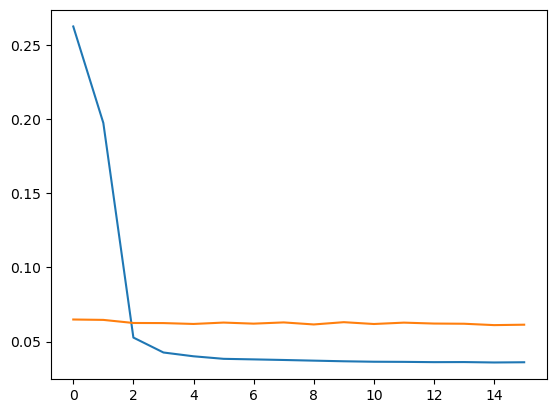

In [70]:
import matplotlib.pyplot as plt

plt.plot(counts)
plt.plot(counts_masked)

In [71]:
expression = []
expression_masked = []
for item in tqdm(rdm.val_dataset):
    expression.append(item['expression_target'])
    expression_masked.append(item['expression_target'][item['mask']])
expression = torch.stack(expression, dim=0)
expression_masked = torch.stack(expression_masked, dim=0)
values, counts = torch.unique(expression, return_counts=True)
values, counts_masked = torch.unique(expression_masked, return_counts=True)
counts = counts / counts.sum()
counts_masked = counts_masked / counts_masked.sum()

100%|██████████| 97/97 [00:00<00:00, 124.51it/s]


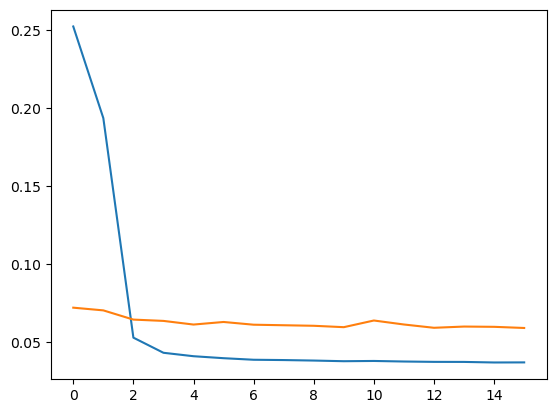

In [72]:
plt.plot(counts)
plt.plot(counts_masked)

In [73]:
train_var = rdm.train_dataset.var_indices
test_var = torch.where(rdm.val_dataset.mask_bool)[0]

In [74]:
print(torch.all(~torch.isin(train_var, test_var)))
print(torch.all(~torch.isin(test_var, train_var)))

tensor(True)
tensor(True)


In [75]:
item = rdm.train_dataset[10]
print(torch.all(torch.isin(item['var_indices'], train_var)))
print(torch.all(~torch.isin(item['var_indices'], test_var)))

tensor(True)
tensor(True)


In [76]:
item = rdm.train_dataset[10]
mask_var = item['var_indices'][item['mask']]
print(torch.all(torch.isin(mask_var, train_var)))
print(torch.all(~torch.isin(mask_var, test_var)))

tensor(True)
tensor(True)


In [77]:
item = rdm.val_dataset[10]
mask_var = item['var_indices'][item['mask']]
print(torch.all(~torch.isin(mask_var, train_var)))
print(torch.all(torch.isin(mask_var, test_var)))

tensor(True)
tensor(True)


#### Look at predict dataset

In [78]:
item = rdm.predict_dataset[0]
print(item['mask'].sum())
print(len(item['mask']))

tensor(5792)
19431


In [80]:
item = rdm.predict_dataset[10]
mask_var = item['var_indices'][item['mask']]
print(torch.all(~torch.isin(mask_var, train_var)))
print(torch.all(torch.isin(mask_var, test_var)))
print(torch.all(torch.isin(test_var, mask_var)))

tensor(True)
tensor(True)
tensor(True)


In [81]:
expression = []
expression_masked = []
for item in tqdm(rdm.predict_dataset):
    expression.append(item['expression_target'])
    expression_masked.append(item['expression_target'][item['mask']])
expression = torch.stack(expression, dim=0)
expression_masked = torch.stack(expression_masked, dim=0)
values, counts = torch.unique(expression, return_counts=True)
values, counts_masked = torch.unique(expression_masked, return_counts=True)
counts = counts / counts.sum()
counts_masked = counts_masked / counts_masked.sum()

100%|██████████| 97/97 [00:00<00:00, 130.20it/s]


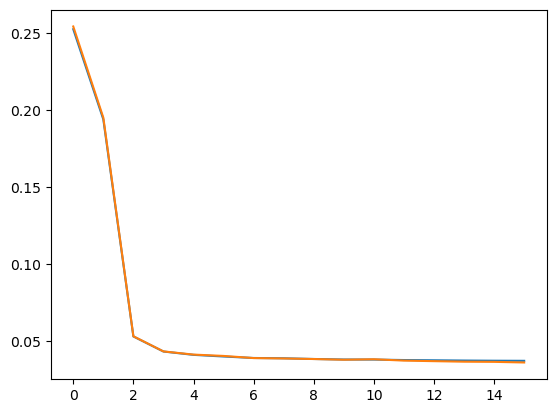

In [82]:
plt.plot(counts)
plt.plot(counts_masked)

## More

In [ ]:
import torch

In [ ]:
torch.unique(rdm.val_dataset[0]['expression'], return_counts=True)

In [ ]:
rdm.val_dataset[0]

In [ ]:
tensor = torch.Tensor(rdm.val_dataset.expression[4].toarray())

In [ ]:
import numpy as np

In [ ]:
val, counts = torch.unique(tensor, return_counts=True)

In [ ]:
n_bins = 16

In [ ]:
# Put all zero values in their own bin and then distribute others evenly
boundaries = torch.quantile(tensor[tensor>0], torch.linspace(0, 1, n_bins))
boundaries = torch.concat([torch.tensor([0]), boundaries])
boundaries[-1] = torch.inf
aa = torch.bucketize(tensor, boundaries, right=True) - 1
torch.unique(aa, return_counts=True)

In [ ]:
# Put all zero values in their own bin and then distribute others evenly
boundaries = torch.quantile(tensor, torch.linspace(0, 1, n_bins))
ab = torch.bucketize(tensor, boundaries)
torch.unique(ab, return_counts=True)

In [ ]:
boundaries = torch.quantile(tensor[tensor>0], torch.linspace(0, 1, n_bins - 1))
tmp = torch.bucketize(tensor[tensor>0], boundaries) + 1
new = torch.zeros_like(tensor).long()
new[tensor > 0] = tmp
torch.unique(new, return_counts=True)

In [ ]:
torch.quantile(tensor, torch.linspace(0, 1, n_bins))

In [ ]:
torch.unique(aa, return_counts=True)

In [ ]:
boundaries

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.bar(val, counts)
plt.ylim([0, 50]);

In [ ]:
torch.quantile(tensor, torch.linspace(0, 1, n_bins))

In [ ]:
torch.quantile(tensor, torch.logspace(0, .301, n_bins) - 1)

In [ ]:
torch.logspace(0, .301, n_bins) - 1

In [ ]:
10**2

In [ ]:
from rosa.utils import score_predictions, plot_expression_and_correlation, plot_marker_gene_heatmap


adata_test, results = score_predictions(adata)

In [ ]:
plot_expression_and_correlation(adata_test, results)

In [ ]:
import numpy as np


marker_genes = adata_test.var[adata_test.var['highly_variable']]['feature_name'].values
np.random.seed(42)
marker_genes = np.random.choice(marker_genes, 50)

plot_marker_gene_heatmap(adata_test, marker_genes)

In [ ]:
marker_genes_dict = adata_test.obs.set_index('label').to_dict()['marker_feature_name']
plot_marker_gene_heatmap(adata_test, marker_genes_dict)